In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns
import os
os.chdir(r"C:\Users\speed\Documents\#Stellar Classification")

import torch
from torch.utils.data import Dataset, DataLoader
import tqdm

In [2]:
class MaStar3(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        yi = self.data[idx]
        yi_scaled = density_minmax(yi, thresh=0.8)

        return torch.Tensor(yi_scaled).to('cuda')

class unified(Dataset):

    def __init__(self, data, lbl):
        self.data = data
        self.labels = lbl

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        yi = self.data['FLUX'][idx]
        np.put(yi, np.where(self.data['FLUX'][idx] == np.inf)[0], 0)

        yi_scaled = density_minmax(yi, thresh=0.8)
        l = self.labels.loc[self.data['NAME'][idx]] 

        return torch.Tensor(yi_scaled), l

def density_minmax(x, thresh = 0.9):
    q = np.quantile(x, q = thresh)
    x_std = (x - x.min(axis=0)) / (q - x.min(axis=0))
    return x_std

def collate_batch(batch):
    b = []
    for flux in batch:
         b.append(flux)

    fluxes = torch.vstack(b)
    return fluxes.to('cuda')

def collate_batch2(batch):
    X = []
    Y = []

    for flux, lbl in batch:
         Y.append(lbl)
         X.append(flux)

    fluxes = torch.vstack(X)
    labels = np.stack(Y)

    return fluxes.to('cuda'), labels

torch.manual_seed('1337')

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

def one_loop(dataloader, model, optimizer, loss):
    ls = []
    
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        pred = model(data.unsqueeze(dim=1))
        l = loss(data.unsqueeze(dim=1), pred)
        ls.append(l.item())
        l.backward()
        optimizer.step()

    return ls

In [3]:
sdss_unlabeled = np.load('processed_sdss_unlabeled2.npy')

cflib_labels = pd.read_csv('cflib_oba.csv', index_col='Name')
cflib_sp = np.load('processed_cflib2.npy')

In [4]:
lum_d = {
    'Ia':1, 'Ib':2,
    'II':3, 'III':4,
    'IV':5, 'V':6,
    'VI':7
}

def class_to_num(row):
    sp = row['spec']
    sp_i = 'OBAFGKM'.index(sp)

    if row.isna()['sub']:
        sub = 5
    else:
        sub = min(round(float(row['sub'])), 9)
        
    if row.isna()['lum']:
        lum_i = 0
    else:
        lum_i = lum_d.get(row['lum'])

    return (sp_i, sub, lum_i)

unlabeled = MaStar3(sdss_unlabeled)
cflib = unified(cflib_sp, cflib_labels.apply(class_to_num, axis=1))

generator = torch.Generator().manual_seed(1337)

dataldr = lambda x: DataLoader(x, batch_size=16,
                       collate_fn=collate_batch2, 
                       worker_init_fn=seed_worker)

sets = torch.utils.data.random_split(cflib, [0.90,0.1,0], generator = generator)

train_set, valid_set, test_set = [dataldr(x) for x in sets]

train_auto = DataLoader(unlabeled, batch_size=32,
                         collate_fn=collate_batch, drop_last=True, 
                         worker_init_fn=seed_worker)

c:\ProgramData\miniconda3\lib\site-packages\torch\utils\data\dataset.py:348: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [5]:
class encoder_block(torch.nn.Module):

    def __init__(self):
        super(encoder_block, self).__init__()

        self.conv1 = torch.nn.Conv1d(1,128,4,2)
        self.conv2 = torch.nn.Conv1d(128,64,4,2)
        self.conv3 = torch.nn.Conv1d(64,32,4,2)
        self.conv4 = torch.nn.Conv1d(32,16,4,2)

        self.down = torch.nn.MaxPool1d(2, return_indices=True)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x, i4 = self.down(x)
        x = self.relu(self.conv2(x))
        x, i3 = self.down(x)
        x = self.relu(self.conv3(x))
        x, i2 = self.down(x)
        x = self.relu(self.conv4(x))
        x, i1 = self.down(x)
        y = (i1, i2, i3, i4)

        return x, y

class decoder_block(torch.nn.Module):

    def __init__(self):
        super(decoder_block, self).__init__()

        self.tconv1 = torch.nn.ConvTranspose1d(16,32,6,2)
        self.tconv2 = torch.nn.ConvTranspose1d(32,64,6,2)
        self.tconv3 = torch.nn.ConvTranspose1d(64,128,5,2)
        self.tconv4 = torch.nn.ConvTranspose1d(128,1,5,2)

        self.up = torch.nn.MaxUnpool1d(2)

        self.relu = torch.nn.ReLU()

    def forward(self, x, y):
        x = self.up(x, y[0])
        x = self.relu(self.tconv1(x))
        x = self.up(x, y[1])
        x = self.relu(self.tconv2(x))
        x = self.up(x, y[2])
        x = self.relu(self.tconv3(x))
        x = self.up(x, y[3])
        x = self.relu(self.tconv4(x))

        return x

class auto(torch.nn.Module):

    def __init__(self, enc, dec):
        super(auto, self).__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        x, y = enc(x)
        x = dec(x, y)

        return x
        
enc = encoder_block().to('cuda')
dec = decoder_block().to('cuda')
auto_encoder = auto(enc, dec).to('cuda')

100%|██████████| 746/746 [00:09<00:00, 76.86it/s]


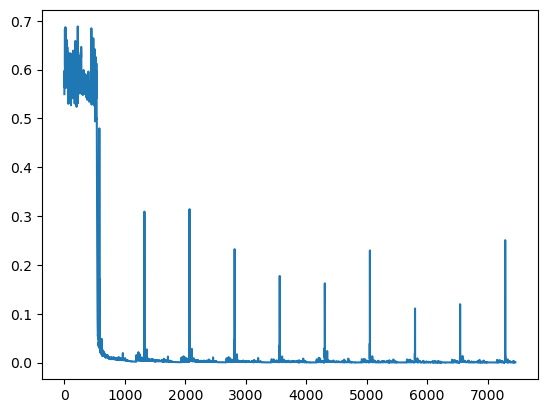

In [6]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(auto_encoder.parameters(), lr=0.0005)
#maybe do learning rate scheduling (start from 0.0005 and get small)

epochs = 10
loss = []

for i in range(epochs):
    l = one_loop(train_auto, auto_encoder, optim, loss_fn)
    loss.extend(l)

plt.plot(loss)

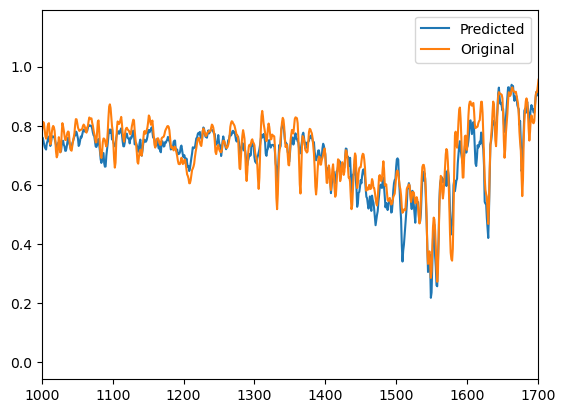

In [7]:
pred = auto_encoder(unlabeled[1500].unsqueeze(dim=0)).squeeze().detach().cpu().numpy()
#plt.plot(pred)
#plt.plot(np.convolve(pred,np.ones([10])/10))
plt.plot(pred)
plt.plot(unlabeled[1500].detach().cpu().numpy())
plt.xlim([1000,1700])
plt.legend(['Predicted', 'Original'])

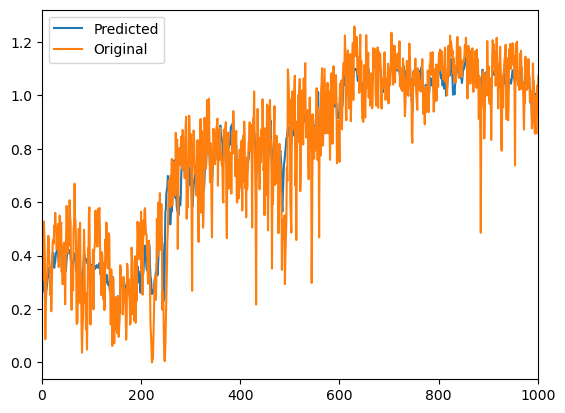

In [8]:
pred2 = auto_encoder(cflib[300][0].to('cuda').unsqueeze(dim=0)).squeeze().detach().cpu().numpy()
plt.plot(pred2)
plt.plot(cflib[300][0].detach().cpu().numpy())
plt.xlim([0,1000])
plt.legend(['Predicted', 'Original'])

In [9]:
class HierarchicalClassifier(torch.nn.Module):
    def __init__(self, enc, hidden_size):
        super(HierarchicalClassifier, self).__init__()
        
        self.enc = enc

        self.linear1 = torch.nn.Linear(240, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size//2)
        self.linear3 = torch.nn.Linear(hidden_size//2, hidden_size//4)
        self.linear4 = torch.nn.Linear(hidden_size//4, 3)

        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.25)
    
    def forward(self, x):
        batch = x.shape[0]
        x, _ = self.enc(x.unsqueeze(dim=1))
        x = x.view(batch,-1)
        
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))

        return x

In [10]:
hidden_size = 128 

model = HierarchicalClassifier(enc, hidden_size).to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #0.0001 before
#lambda1 = lambda epoch: 0.5 ** epoch
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

loss_fn = torch.nn.MSELoss()

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


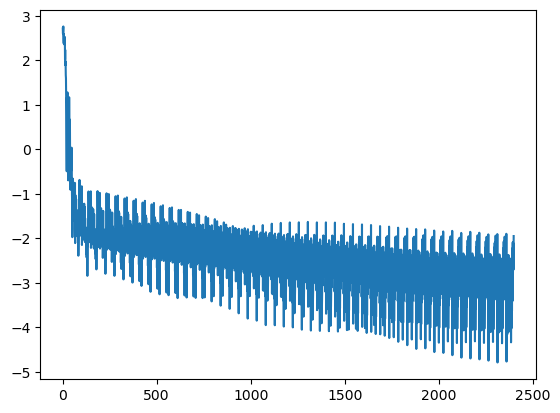

In [11]:
num_epochs = 50

los = []

for epoch in tqdm.tqdm(range(num_epochs)):
    for inputs, labels in train_set:
        optimizer.zero_grad()

        x = model(inputs)

        spec = torch.Tensor(labels).to('cuda')

        spec_loss = loss_fn(x[:,0], spec[:,0])
        sub_loss = loss_fn(x[:,1], spec[:,1])

        total = spec_loss#+sub_loss*0.1

        los.append(total.item())

        total.backward()
        
        optimizer.step()
    #scheduler.step()

plt.plot(np.log(los))

In [18]:
wei = torch.tensor([1,0.1,0]).to('cuda')
preds = np.empty(0)
actuals = np.empty(0)
turn = lambda x: x.detach().cpu().numpy()

model.eval()
with torch.no_grad():
    for inputs, labels in train_set:
        
        x = model(inputs)
        batch = x.shape[0]
        xs = torch.sum(x*wei.repeat(batch,1),axis=1)
        spec = torch.Tensor(labels).long().to('cuda')
        #xs = torch.trunc(x[:,0])+0.1*x[:,1]
        ll = torch.sum(spec*wei.repeat(batch,1),axis=1)

        preds = np.append(preds, turn(xs))
        actuals = np.append(actuals, turn(ll))
model.train()

from sklearn.metrics import f1_score, confusion_matrix, classification_report

acc = f1_score(np.trunc(actuals), np.round(preds), average='micro')
f1 = f1_score(np.trunc(actuals), np.round(preds), average='macro')

print(f'Accuracy: {acc}\nF1:\t  {f1}')

Accuracy: 0.9144736842105263
F1:	  0.7655845197411623


Accuracy: 0.9144736842105263
F1:	  0.7655845197411623


<Axes: >

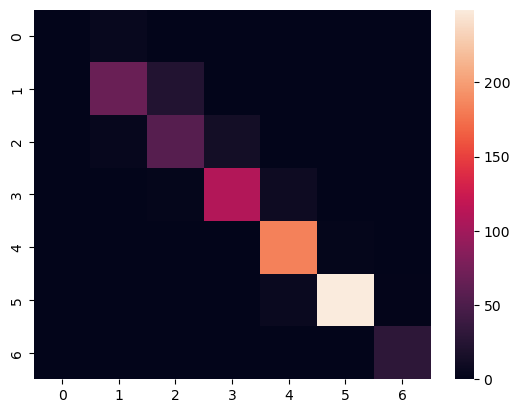

In [19]:
preds[preds>6] = 6

acc1 = f1_score(np.trunc(actuals), np.round(preds), average='micro')
f11 = f1_score(np.trunc(actuals), np.round(preds), average='macro')

print(f'Accuracy: {acc1}\nF1:\t  {f11}')

sns.heatmap(confusion_matrix(np.trunc(actuals), np.round(preds)))

In [20]:
print(classification_report(np.trunc(actuals), np.round(preds), zero_division=0))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.88      0.75      0.81        91
         2.0       0.69      0.77      0.73        73
         3.0       0.89      0.91      0.90       120
         4.0       0.92      0.99      0.96       185
         5.0       0.99      0.97      0.98       256
         6.0       0.97      1.00      0.98        30

    accuracy                           0.91       760
   macro avg       0.76      0.77      0.77       760
weighted avg       0.91      0.91      0.91       760



<ipython-input-21-c0d8ab6d85df>:6: RuntimeWarning: invalid value encountered in divide
  rec = c/c.sum(axis=0)
<ipython-input-21-c0d8ab6d85df>:7: RuntimeWarning: divide by zero encountered in divide
  f1_ = 2/(1/prec+1/rec)


<Axes: >

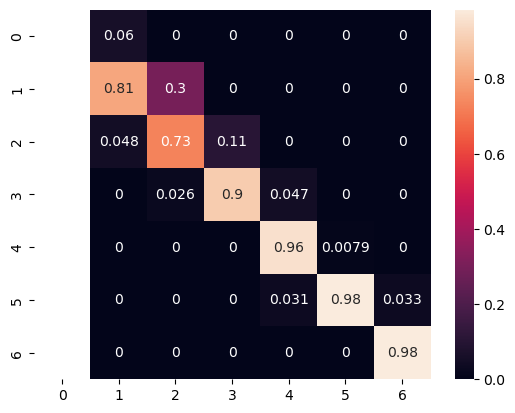

In [21]:
c = confusion_matrix(np.trunc(actuals), np.round(preds))

prec = c/c.sum(axis=1)
rec = c/c.sum(axis=0)
f1_ = 2/(1/prec+1/rec)

sns.heatmap(f1_, annot=True)